**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

# reading data from lesson 2
df_raw = pd.read_feather('tmp/bulldozers-raw')
# fill in missing values, convert cats to nums, pull out target (dependent variable)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

print(df_trn.shape)
print(y_trn.shape)
nas # keys - numeric cols with missing values, values are the medians

(401125, 66)
(401125,)


{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

**Note**:

`nas` is a dictionary of the columns (the keys) which had missing values and the medians (the values) for each of those columns.

You can pass `nas` to `proc_df` (3rd arg) when pre-processing your test dataset to ensure it uses those same median values in those columns for any missing values.

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid

# split the data into training and validation data sets
X_train, X_valid = split_vals(df_trn, n_trn) # data
y_train, y_valid = split_vals(y_trn, n_trn) # labels
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [12]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
X_train.sample(5).T

(389125, 66) (12000, 66) (389125,) (12000,)


,100119,30844,294638,181606,372141
SalesID,1418134,1262753,2221817,1615039,2651701
MachineID,112243,1231827,208628,1371496,1872940
ModelID,3357,3206,1192,4721,11402
datasource,132,132,136,132,149
auctioneerID,1,6,1,2,1
YearMade,1993,1977,1997,1978,2007
MachineHoursCurrentMeter,0,0,0,0,5588
UsageBand,-1,-1,-1,-1,0
fiModelDesc,82,1254,566,1037,1281
fiBaseModel,19,370,189,322,376


In [6]:
# helper functions
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train), 
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train), 
        m.score(X_valid, y_valid)
    ]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [13]:
# set the number of sample the random forest will use to train the model
# big enough that if the model is run multiple times, you don't get diff results
set_rf_samples(50000)

In [14]:
m = RandomForestRegressor(
    n_estimators=40, 
    min_samples_leaf=3, 
    max_features=0.5, 
    n_jobs=-1, 
    oob_score=True
)
m.fit(X_train, y_train)
print_score(m)

[0.20624435104702943, 0.24917825126120494, 0.911100575292332, 0.8891161641593381, 0.8940667074204467]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [15]:
# go through each estimator (model) on our 'forest', calling 'predict' on it
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# grab the first prediction and compute the mean and std for one observation
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 2.07 s, sys: 36 ms, total: 2.1 s
Wall time: 2.1 s


(9.239195859049882, 0.17912071530538137)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [25]:
# Python is single threaded, running on a single core
# 'parallel_trees' fastai func that parallizes the func that is passed
# it takes a random forest (1st arg) and a function to call (2nd arg)
# returns a list of the predictions
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
print(preds.shape) # 40 estimators, 1 pred from each
print()
print(preds)
print()
print(preds[:, 0]) # 40 rows, 1st column
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 100 ms, sys: 108 ms, total: 208 ms
Wall time: 1.11 s
(40, 12000)

[[ 9.12543  9.75814  9.22501 ... 10.34713  9.22181  9.22181]
 [ 9.06572  9.27894  8.97369 ...  9.0339   9.32139  9.32139]
 [ 9.18337  9.06687  9.0538  ... 10.0376   9.18399  9.18399]
 ...
 [ 9.39197  9.78808  9.83086 ...  9.21894  8.92812  8.92812]
 [ 9.45007  9.22784  9.12162 ...  9.26586  9.58955  9.58955]
 [ 9.31783  9.84653  9.42747 ...  9.55342  9.28472  9.28472]]

[9.12543 9.06572 9.18337 9.58897 9.25693 9.41409 9.03871 9.31038 9.06687 9.19971 9.27714 9.70723 9.22191
 9.36498 9.66149 9.07247 8.97661 9.21299 9.06469 9.01324 9.20775 9.38653 9.10997 9.26271 9.21805 9.18449
 9.38198 9.2515  9.13132 8.96568 9.14213 9.21565 9.57862 9.02488 9.17614 9.12105 9.2266  9.39197 9.45007
 9.31783]


(9.239195859049882, 0.17912071530538137)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

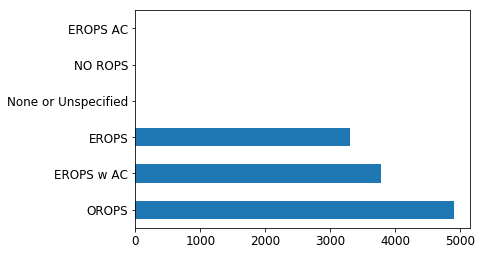

In [27]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [28]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.840433,0.275609
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.582238,0.262251
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684071,0.218074


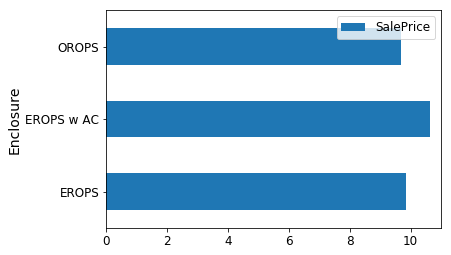

In [29]:
# plot the sale price for each level of enclosure
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

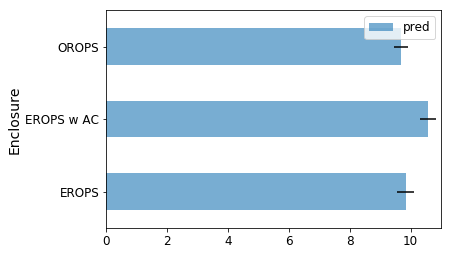

In [30]:
# plot the prediction for each level of enclosure, error bars (confidence interval)
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

**This will tell us if there are any groups or rows that we are not confident of**.

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

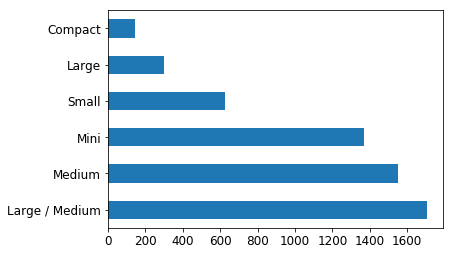

In [31]:
# repeating the process for product size
raw_valid.ProductSize.value_counts().plot.barh();

In [32]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.867254,0.343255
Large,10.470589,10.380601,0.351727
Large / Medium,10.691871,10.649354,0.301198
Medium,10.681511,10.623384,0.281637
Mini,9.535147,9.565710,0.253926
Small,10.324448,10.321752,0.299489


We can calculate the ratio of the standard deviations of the predictions to the predictions themselves (we expect on average that when you are predicting something that is a bigger number, that your std would be bigger) - the ratios should be approx. the same.

In [33]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034787
Large             0.033883
Small             0.029015
Large / Medium    0.028283
Mini              0.026545
Medium            0.026511
dtype: float64

We can see that our predictions for `Large` and `Compact` are less accurate. We can see from the histogram that they are the smallest groups - with smaller groups the estimators are doing a poorer job of predicitions since they have fewer examples to train on.

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

You want to build a random forest as quickly as possible, even if it is only just better than average (baseline model) - to determine which are the columns which matter.

The `fastai` library has the `rf_feat_importance` function which takes a random forest model (train 1st) and dataframe and returns a dataframe with the columns in order of importance.

In [37]:
# returns a list of the columns in order of importance
fi = rf_feat_importance(m, df_trn);
print(fi.shape)
fi[:10] 

(66, 2)


,cols,imp
5,YearMade,0.175323
13,ProductSize,0.105596
37,Coupler_System,0.088371
14,fiProductClassDesc,0.077047
38,Grouser_Tracks,0.065214
2,ModelID,0.056591
63,saleElapsed,0.050183
39,Hydraulics_Flow,0.042262
10,fiSecondaryDesc,0.041710
19,Enclosure,0.032884


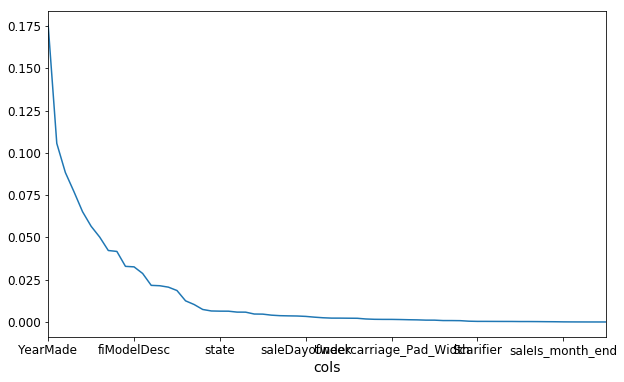

In [38]:
# plot of feature importance vs columns
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

We can see that some columns are really important, e.g. `YearMade`, while many are of little to no importance. Means you can focus on the columns which matter.

In [39]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

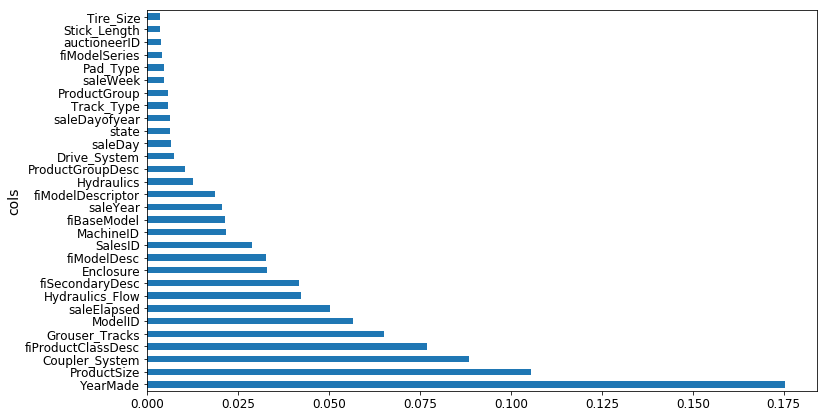

In [40]:
plot_fi(fi[:30]); # plot the top 30 cols

In [41]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,20), legend=False)

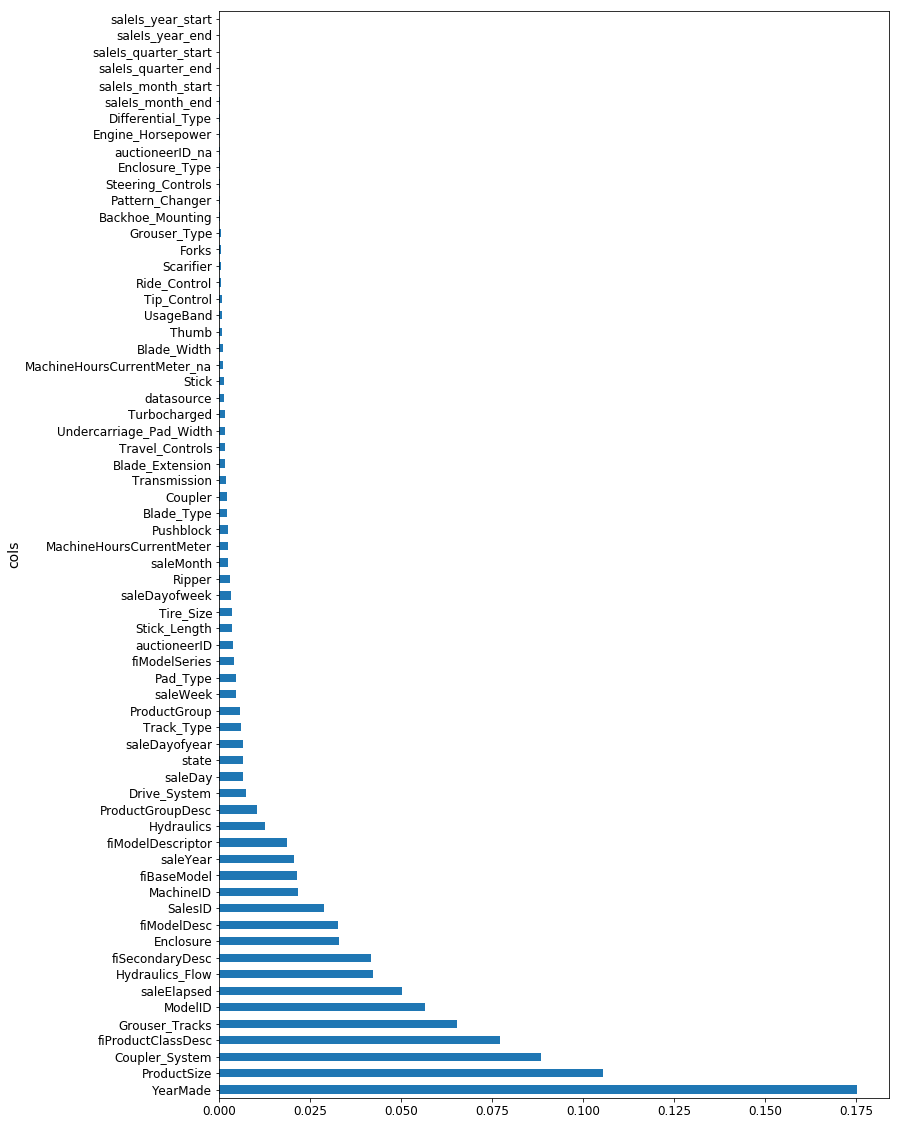

In [42]:
# plotting all columns
plot_fi(fi)

In [44]:
# filter out any columns where imp <= 0.005 (where the results flatten off)
to_keep = fi[fi.imp > 0.005].cols;
print('num cols remaining:', len(to_keep))
print(to_keep)

num cols remaining: 24
5               YearMade
13           ProductSize
37        Coupler_System
14    fiProductClassDesc
38        Grouser_Tracks
2                ModelID
63           saleElapsed
39       Hydraulics_Flow
10       fiSecondaryDesc
19             Enclosure
8            fiModelDesc
0                SalesID
1              MachineID
9            fiBaseModel
51              saleYear
12     fiModelDescriptor
30            Hydraulics
17      ProductGroupDesc
18          Drive_System
54               saleDay
15                 state
56         saleDayofyear
40            Track_Type
16          ProductGroup
Name: cols, dtype: object


Create a dataframe with just those columns, and split into training and validation sets.

In [45]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn) # split into train and val sets

We'll train a new model with the 'important columns.

In [46]:
m = RandomForestRegressor(
    n_estimators=40, 
    min_samples_leaf=3, 
    max_features=0.5,
    n_jobs=-1, 
    oob_score=True
)
m.fit(X_train, y_train)
print_score(m)

[0.20706230810451345, 0.2448017736032496, 0.9103940337001662, 0.8929770065889182, 0.8939664673765082]


Very slight improvement in R^2 (0.892 vs 0.889).

When removing redundant cols, you also remove sources of co-linearity, i.e' two cols that might be related to each other. Results in making your feature plot clearer - gives you a better picture of which columns are important.

In [48]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

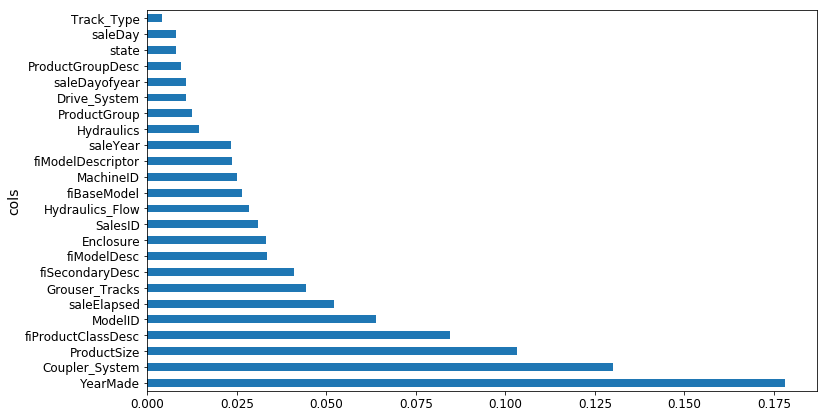

In [49]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

This is a technique that you can use for almost any model.

To determine the impact of each of these columns on the accuracy of predictions (R^2 and RMSE), taking each column in turn:

* shuffle that particular column, carry out the predictions, calculate R^2/RMSE and determine the difference with the original scores.
* repeat this for each column and draw up a table of the differences.

Additionally:

* Find out what you can about each variable, plot it's histogram, create a scatterplot of it vs the target variable.
* Do any appear to have a lot of 'noise'
* Are any of the variables high cardinality categorical which could be split into multiple columns.

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [ ]:
from scipy.cluster import hierarchy as hc

In [ ]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [ ]:
get_oob(df_keep)

Now we try removing each variable one at a time.

In [ ]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

It looks like we can try one from each group for removal. Let's see what that does.

In [ ]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [ ]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [ ]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# Partial dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [ ]:
plot_pdp('YearMade')

In [ ]:
plot_pdp('YearMade', clusters=5)

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

In [ ]:
contributions[0].sum()

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_valid[feats]/1000).describe()

In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)